La reconnaissance des émotions est un sujet d’une complexité considérable pour
l’être humain, tout en présentant un potentiel significatif. Que ce soit dans le
domaine du marketing, où elle peut être utilisée pour analyser les avis sur les
produits, dans le domaine de la psychologie, ou dans d’autres domaines, cette
question revêt une importance majeure et pourrait être automatisée.
Notre projet s’articule autour de la détection automatique des émotions dans les
conversations textuelles. Notre objectif est de répondre à la problématique suivante :

Comment détecter les diverses émotions présentes au sein d’une conversation
textuelle ?




# Importation des librairies et des données

In [1]:
# Installation des librairies nécessaires
!pip install seaborn
!pip install spacy
!pip install Optuna
!python -m spacy download fr_core_news_sm

# Imports des librairies
import base64
import re
import sys
import time
import pickle
import string
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from bs4 import BeautifulSoup
from scipy.stats import randint
from tabulate import tabulate

import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import RegexpParser
from nltk import sent_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     KFold, GridSearchCV)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer,
                                             TfidfTransformer)
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import random
import pandas as pd
from nltk.corpus import wordnet as wn


from spacy.lang.fr import French
from spacy.tokens import Span

nlp = spacy.load("fr_core_news_sm")
stop_words = spacy.lang.fr.stop_words.STOP_WORDS


import optuna
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 39.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

my_local_drive='/content/gdrive/My Drive/TER'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
%cd $my_local_drive

%ls

Mounted at /content/gdrive/
/content/gdrive/My Drive/TER
backup.ipynb               lc_model_Surprise.joblib   rf_model_Surprise.joblib
dataset/                   lc_model_Tristesse.joblib  rf_model_Tristesse.joblib
emotion_classifier.joblib  modele.ipynb               svm_model_Amour.joblib
fonctions.py               __pycache__/               svm_model_Colère.joblib
lc_model_Amour.joblib      rf_model_Amour.joblib      svm_model_Déception.joblib
lc_model_Colère.joblib     rf_model_Colère.joblib     svm_model_Dégoût.joblib
lc_model_Déception.joblib  rf_model_Déception.joblib  svm_model_Honte.joblib
lc_model_Dégoût.joblib     rf_model_Dégoût.joblib     svm_model_Joie.joblib
lc_model_Honte.joblib      rf_model_Honte.joblib      svm_model_Neutre.joblib
lc_model_Joie.joblib       rf_model_Joie.joblib       svm_model_Peur.joblib
lc_model_Neutre.joblib     rf_model_Neutre.joblib     svm_model_Surprise.joblib
lc_model_Peur.joblib       rf_model_Peur.joblib       svm_model_Tristes

In [3]:
# Nos fonctions
import fonctions
from fonctions import *

In [4]:
df=pd.read_csv('dataset/data.csv', sep=',')
display (df.head())

id                                           phrase émotion
0  11  Je n'ai pas besoin de jurer, puisque je t'aime.   Amour
1  12                Tu feras tout ce que je te dirai.  Colère
2  13                     Tout, Caligula, mais arrête.  Colère
3  14                                Tu seras cruelle.  Colère
4  16                            Froide et implacable.  Dégoût

# Pré-traitement



Dans le domaine du Machine Learning, et plus précisément dans les projets de reconnaissance des émotions à partir de données textuelles, le prétraitement des données joue un rôle crucial.

 Les données textuelles brutes sont souvent désordonnées et pleines de bruit. Elles peuvent contenir des erreurs de frappe, des abréviations, des mots argotiques, des émojis, et d'autres formes de texte non structuré qui peuvent rendre difficile l'analyse des émotions.

  Avant de pouvoir entraîner efficacement un modèle de Machine Learning sur ces données, il est essentiel de les nettoyer et de les structurer.

In [5]:
# Cast des phrases en string
df = df.dropna(subset=['phrase'])
df = df.copy()
df['phrase'] = df['phrase'].astype(str)

In [6]:
# Suppression des classes minoritaires
def remove_minority_classes_inplace(df, target_column, min_instances):
    class_counts = df[target_column].value_counts()
    minority_classes = class_counts[class_counts < min_instances].index
    df.drop(df[df[target_column].isin(minority_classes)].index, inplace=True)

remove_minority_classes_inplace(df, 'émotion', min_instances=100)

counts = df['émotion'].value_counts()

print(counts)

émotion
Joie         456
Surprise     333
Colère       322
Peur         317
Honte        317
Amour        305
Neutre       301
Dégoût       300
Tristesse    290
Déception    289
Name: count, dtype: int64


In [7]:
# Fonction pour ajouter des synonymes dans une phrase
def add_synonyms(phrase, emotion):
    words = phrase.split()
    if len(words) > 0:
        target_word = random.choice(words)
        synonyms = [synset.lemmas()[0].name() for synset in wn.synsets(target_word)]
        if synonyms:
            random_synonym = random.choice(synonyms)
            return phrase.replace(target_word, random_synonym)
    return phrase

# Fonction pour supprimer des mots dans une phrase
def remove_words(phrase,emotion):
    words = phrase.split()
    if len(words) > 1:
        word_to_remove = random.choice(words)
        words.remove(word_to_remove)
    return ' '.join(words)


# Fonction pour ajouter un mot dans une phrase
def add_word(phrase, emotion):
    words_for_emotion = liste_mots_par_emotion[emotion]
    word_to_add = random.choice(words_for_emotion)
    return phrase + ' ' + word_to_add


# Nombre cible de phrases par classe
number_of_classes = 600


df_new = df.copy()


new_data = []

liste_mots_par_emotion = {
    'Joie': ['heureux', 'merveilleux', 'épanoui', 'rayonnant', 'positif'],
    'Tristesse': ['triste', 'abattu', 'désespéré', 'sombrer', 'mélancolique'],
    'Colère': ['colère', 'furieux', 'irrité', 'agressif', 'fâché'],
    'Peur': ['effrayé', 'terrifié', 'paniqué', 'angoissé', 'craintif'],
    'Surprise': ['étonné', 'surpris', 'stupéfait', 'ébahi', 'interloqué'],
    'Honte': ['honteux', 'humilié', 'coupable', 'gêné', 'confus'],
    'Déception': ['déçu', 'désillusionné', 'insatisfait', 'frustré', 'trompé'],
    'Dégoût': ['dégoûté', 'répugné', 'écœuré', 'déplaisant', 'révoltant'],
    'Amour': ['amour', 'passion', 'tendresse', 'affection', 'attachement'],
    'Neutre': ['rien', 'neutre', 'calme', 'stable'],
}


generation_methods = [ add_synonyms, remove_words, add_word]


for emotion in df['émotion'].unique():
    if emotion != number_of_classes:
        subset = df[df['émotion'] == emotion]
        current_count = len(subset)

        # Calcul du nombre de nouvelles phrases à générer
        num_new_phrases = number_of_classes - current_count

        for _ in range(num_new_phrases):
            random_phrase = random.choice(subset['phrase'].values)


            chosen_method = random.choice(generation_methods)

            new_phrase = chosen_method(random_phrase, emotion)


            # Ajout de la nouvelle phrase générée à la liste
            new_data.append({
                'id': df['id'].max() + len(new_data) + 1,
                'phrase': new_phrase,
                'émotion': emotion
            })


df_new = pd.concat([df, pd.DataFrame(new_data)], ignore_index=True)





In [ ]:
counts = df_new['émotion'].value_counts()
print(counts)

Amour        600
Colère       600
Dégoût       600
Déception    600
Neutre       600
Joie         600
Surprise     600
Tristesse    600
Peur         600
Honte        600
Name: émotion, dtype: int64


In [ ]:
stop_words_point = ['.',',']

class TextStemmer:
    def __init__(self):
        self.stemmer = nltk.stem.SnowballStemmer('french')
        self.stop_words_french = set(stopwords.words('french'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stemmed_texts = []
        for text in X:
            tokens = word_tokenize(text)
            stemmed_tokens = [self.stemmer.stem(token.lower()) for token in tokens
                              if token.lower() not in self.stop_words_french
                              and token.lower() not in stop_words_point
                              ]
            stemmed_text = ' '.join(stemmed_tokens)
            stemmed_texts.append(stemmed_text)
        return stemmed_texts

    def transform_and_save(self, df, text_column_name, new_column_name):
        df[new_column_name] = self.transform(df[text_column_name])


X = df_new['phrase']

text_stemmer = TextStemmer()
text_stemmer.fit(X)
text_stemmer.transform_and_save(df_new, 'phrase', 'stemmed_text')

display(df_new.head())

id                                           phrase émotion  \
0  11  Je n'ai pas besoin de jurer, puisque je t'aime.   Amour   
1  12                Tu feras tout ce que je te dirai.  Colère   
2  13                     Tout, Caligula, mais arrête.  Colère   
3  14                                Tu seras cruelle.  Colère   
4  16                            Froide et implacable.  Dégoût   

                   stemmed_text  
0  n'ai besoin jur puisqu t'aim  
1                  fer tout dir  
2            tout caligul arrêt  
3                         cruel  
4                  froid implac

# Recherche des meilleures pipelines

Afin de déterminer les algorithmes les plus adaptés à nos données, nous effectuons des tests avec plusieurs classifieurs en utilisant la validation croisée.

In [ ]:
pipelines = [
    ("Avec tfidf et multiNB", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])),
    ("Avec tfidf et SVC", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', SVC())
    ])),
    ("Avec tfidf et RandomForest", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier())
    ])),
    ("Avec tfidf et LogisticRegression", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])),
    ("Avec tfidf et DecisionTreeClassifier", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier())
    ])),
    ("Avec tfidf et KNeighborsClassifier", Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', KNeighborsClassifier())
    ])),


]

# Évaluation de chaque pipeline en utilisant une validation croisée
X = df_new['stemmed_text']
y = df_new['émotion']
results = []
names = []
scoring = 'accuracy'

print("Résultats avec Stemmed_text:")
for name, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X, y, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

print("\nMeilleur résultat avec Stemmed_text:")
best_index = np.argmax([cv.mean() for cv in results])
print("Classifieur :", names[best_index])
print("%s : %0.3f" % (scoring, results[best_index].mean()))
print("(%0.3f)" % results[best_index].std())

Résultats avec Stemmed_text:
Avec tfidf et multiNB: 0.804500 (0.062289)
Avec tfidf et SVC: 0.891500 (0.059557)
Avec tfidf et RandomForest: 0.864333 (0.064402)
Avec tfidf et LogisticRegression: 0.821167 (0.062886)
Avec tfidf et DecisionTreeClassifier: 0.806333 (0.069479)
Avec tfidf et KNeighborsClassifier: 0.596667 (0.076707)

Meilleur résultat avec Stemmed_text:
Classifieur : Avec tfidf et SVC
accuracy : 0.891
(0.060)


In [ ]:
def classification(classifier, X_train, y_train, X_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return y_pred


# Premier classifieur : LogisticRegression

Méthode fit(X, y) :

Cette méthode est utilisée pour entraîner le modèle de régression logistique sur les données d'entraînement.
Les paramètres X représentent les caractéristiques (features) des données d'entraînement et y représente les étiquettes (labels) correspondantes.
À l'intérieur de cette méthode, les poids (coefficients) et le biais du modèle sont initialisés avec des valeurs nulles.
Ensuite, une boucle est exécutée sur un nombre donné d'itérations. À chaque itération, les prédictions sont calculées en utilisant les caractéristiques et les paramètres actuels du modèle.
Ensuite, les gradients sont calculés à l'aide de la dérivée de la fonction de perte par rapport aux poids et au biais.
Les poids et le biais sont ensuite mis à jour en fonction des gradients et du taux d'apprentissage (learning rate), dans le but de minimiser la fonction de perte et d'améliorer les prédictions du modèle.


Méthode predict(X) :

Cette méthode est utilisée pour effectuer des prédictions sur de nouvelles données après que le modèle a été entraîné avec la méthode fit.
Le paramètre X représente les caractéristiques des nouvelles données sur lesquelles nous voulons faire des prédictions.
À l'intérieur de cette méthode, les prédictions sont calculées en utilisant les poids et le biais appris lors de l'entraînement du modèle.
Les valeurs prédites sont transformées en probabilités en utilisant la fonction sigmoïde, qui renvoie des valeurs dans l'intervalle [0, 1].
Enfin, un seuil de 0.5 est appliqué pour classer les exemples en fonction de leurs probabilités. Par exemple, si la probabilité prédite est supérieure à 0.5, l'exemple est classé comme classe positive (1), sinon il est classé comme classe négative (0).




In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogisticRegression_:

    def __init__(self, lr=0.001, n_iters=4000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions-y)

            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db


    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

Mesures d'évaluation :
Accuracy : 0.90
Precision : 0.92
Recall : 0.86
F1 Score : 0.89


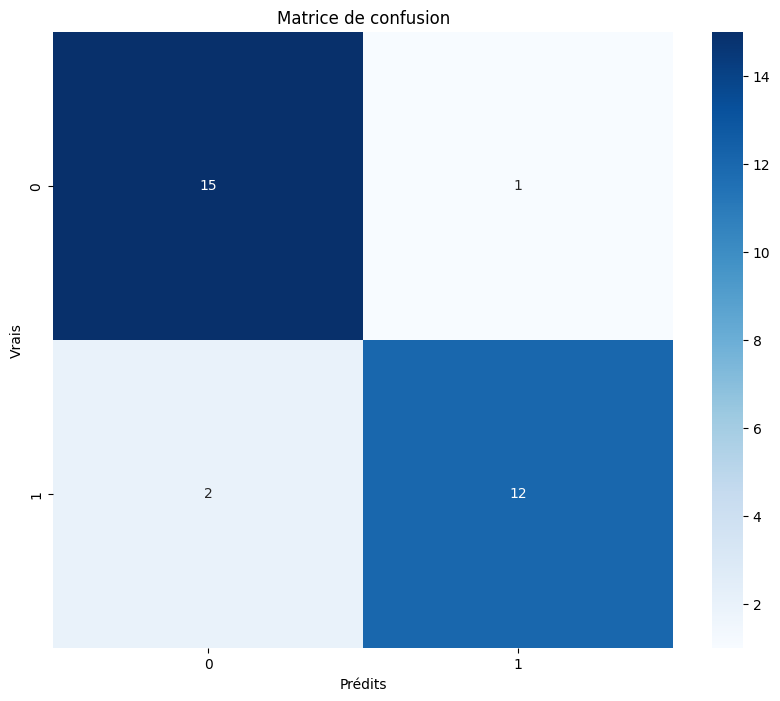

In [ ]:
X_train, X_test, y_train, y_test = creation_donnes()

modele = LogisticRegression_()
modele.fit(X_train, y_train)
y_pred = modele.predict(X_test)

print_evaluation_metrics_binary(y_test, y_pred)

Maintenant on test sur nos données

In [ ]:
best_pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

Mesures d'évaluation :
Accuracy : 0.81
Precision : 0.81
Recall : 0.81
F1 Score : 0.81


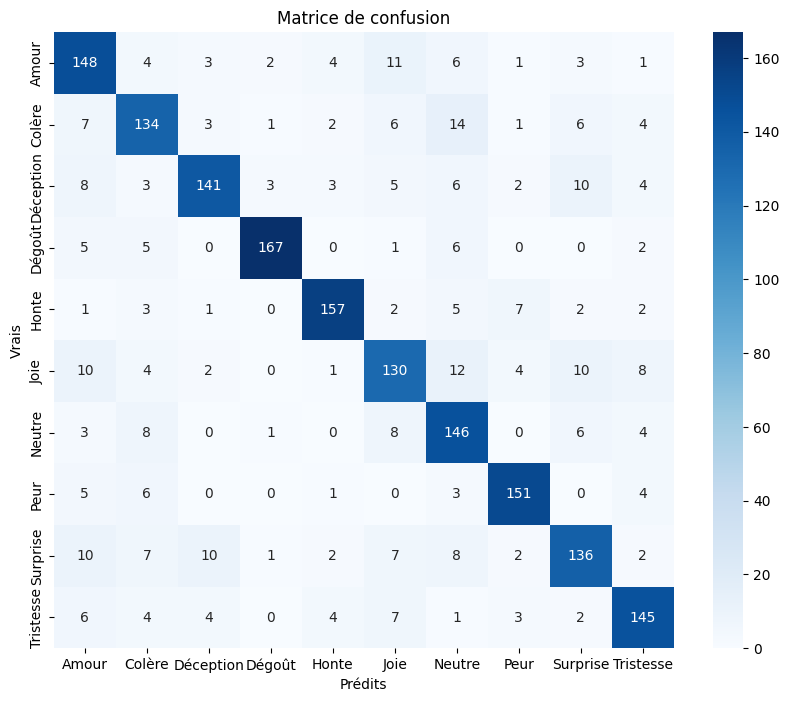

In [ ]:
X = df_new['stemmed_text']
y = df_new['émotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

y_pred = classification(best_pipeline_1,X_train,y_train,X_test)
print_evaluation_metrics(y_test, y_pred)


# Second classifieur : RandomForest

Classe DecisionTree :

Cette classe représente un arbre de décision binaire.
Le constructeur __init__ prend en charge plusieurs hyperparamètres, tels que max_depth, min_samples_split et min_samples_leaf, qui déterminent la structure de l'arbre.


La méthode fit(X, y) est utilisée pour entraîner l'arbre de décision sur les données d'entraînement X avec les étiquettes correspondantes y.


La méthode _build_tree(X, y, depth) est une méthode interne qui construit récursivement l'arbre en choisissant les meilleurs splits à chaque nœud en fonction d'un critère d'impureté (gini).


La méthode _find_best_split(X, y) cherche la meilleure division pour chaque caractéristique en calculant l'impureté de Gini.


La méthode _gini_impurity(left_labels, right_labels) calcule l'impureté de Gini pour une division donnée.


La méthode _most_common_label(y) retourne l'étiquette la plus fréquente dans un ensemble d'étiquettes.


Classe RandomForest_ :

Cette classe représente un classificateur de forêt aléatoire, qui entraîne plusieurs arbres de décision sur des sous-ensembles aléatoires des données d'entraînement.


Le constructeur __init__ prend en charge des hyperparamètres similaires à ceux de DecisionTree, ainsi que n_estimators, qui spécifie le nombre d'arbres dans la forêt.


La méthode fit(X, y) est utilisée pour entraîner la forêt aléatoire en ajustant un ensemble d'arbres de décision sur des sous-ensembles aléatoires des données d'entraînement.


La méthode predict(X) est utilisée pour faire des prédictions sur de nouvelles données X en agrégeant les prédictions de chaque arbre dans la forêt et en choisissant la classe majoritaire.

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Critère d'arrêt : si tous les labels sont les mêmes ou si la profondeur maximale est atteinte
        if num_labels == 1 or (self.max_depth is not None and depth == self.max_depth) or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return {'leaf': True, 'value': leaf_value}

        # Recherche de la meilleure séparation
        best_split = self._find_best_split(X, y)
        if best_split is None:
            leaf_value = self._most_common_label(y)
            return {'leaf': True, 'value': leaf_value}

        # Diviser les données en fonction de la meilleure séparation
        left_indices = best_split['left_indices']
        right_indices = best_split['right_indices']
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'leaf': False,
                'feature_index': best_split['feature_index'],
                'threshold': best_split['threshold'],
                'left': left_subtree,
                'right': right_subtree}

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = float('inf')
        best_split = None

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue

                gini = self._gini_impurity(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_split = {'feature_index': feature_index,
                                  'threshold': threshold,
                                  'left_indices': left_indices,
                                  'right_indices': right_indices}

        return best_split

    def _gini_impurity(self, left_labels, right_labels):
        num_left = len(left_labels)
        num_right = len(right_labels)
        total = num_left + num_right
        gini_left = 1.0 - sum((np.sum(left_labels == label) / num_left) ** 2 for label in np.unique(left_labels))
        gini_right = 1.0 - sum((np.sum(right_labels == label) / num_right) ** 2 for label in np.unique(right_labels))
        gini = (num_left / total) * gini_left + (num_right / total) * gini_right
        return gini

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        predictions = np.zeros(len(X))
        for i in range(len(X)):
            predictions[i] = self._traverse_tree(X[i], self.tree)
        return predictions.astype(int)

    def _traverse_tree(self, x, node):
        if node['leaf']:
            return node['value']
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])


class RandomForest_:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            bootstrap_X = X[bootstrap_indices]
            bootstrap_y = y[bootstrap_indices]
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for tree in self.trees:
            predictions += tree.predict(X)
        return (predictions > (len(self.trees) / 2)).astype(int)


Mesures d'évaluation :
Accuracy : 0.97
Precision : 1.00
Recall : 0.93
F1 Score : 0.96


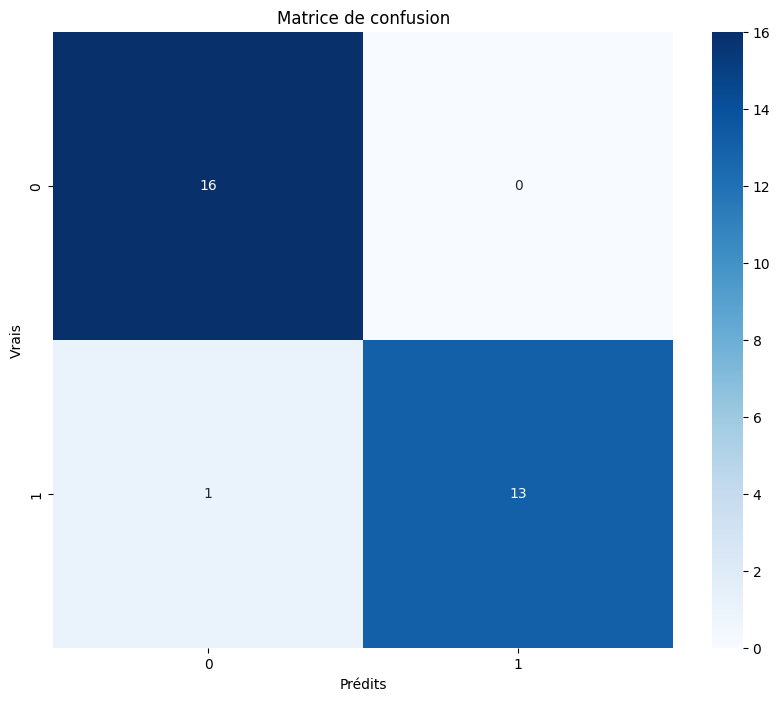

In [ ]:
X_train, X_test, y_train, y_test = creation_donnes()

modele = RandomForest_()
modele.fit(X_train, y_train)
y_pred = modele.predict(X_test)

print_evaluation_metrics_binary(y_test, y_pred)

Maintenant on test sur nos données

In [ ]:
best_pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Mesures d'évaluation :
Accuracy : 0.83
Precision : 0.84
Recall : 0.83
F1 Score : 0.83


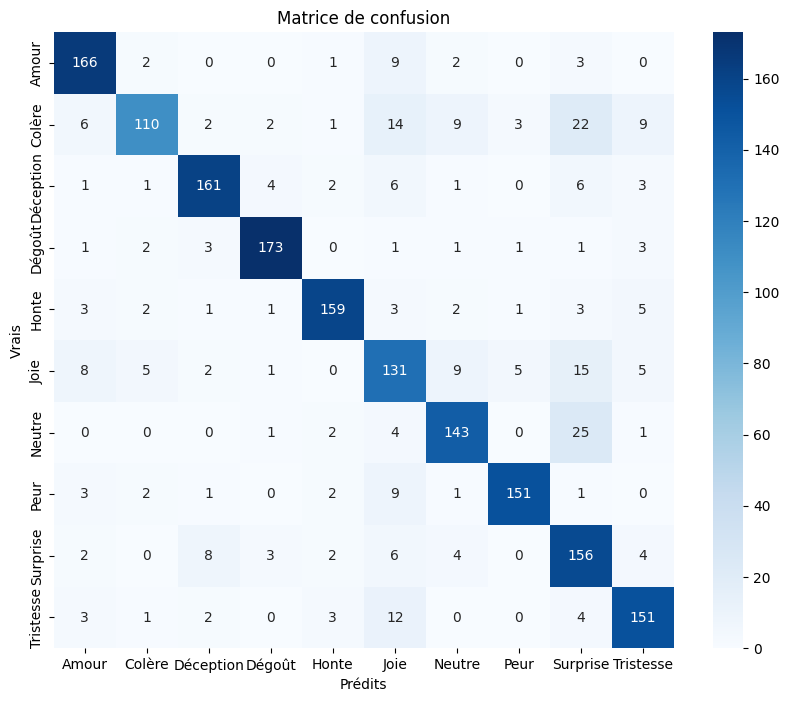

In [ ]:
best_pipeline_2.fit(X_train, y_train)

y_pred = best_pipeline_2.predict(X_test)

print_evaluation_metrics(y_test, y_pred)


# Troisième classifieur : SVC

Initialisation de la classe SVM_ :

La classe SVM_ est initialisée avec trois paramètres principaux : le taux d'apprentissage (learning_rate), le paramètre de régularisation lambda (lambda_param), et le nombre d'itérations (n_iters). Ces paramètres contrôlent le processus d'apprentissage de la SVM.


Deux autres variables, self.w et self.b, sont initialisées à None. Ces variables représentent les poids et le biais du modèle SVM et seront déterminées lors de l'apprentissage.


Méthode fit :

Cette méthode est utilisée pour entraîner le modèle SVM en ajustant les poids self.w et le biais self.b à partir des données d'entraînement X et des étiquettes y.


Les étiquettes y sont transformées en -1 et 1 à l'aide de np.where, où les valeurs négatives deviennent -1 et les valeurs positives deviennent 1, ce qui est typique pour les SVM.


Les poids self.w sont initialisés à l'aide de l'initialisation Xavier/Glorot, qui est une méthode courante pour initialiser les poids des réseaux de neurones.
Le processus d'apprentissage est effectué sur un certain nombre d'itérations défini par n_iters. À chaque itération, les poids sont ajustés en fonction de l'erreur de prédiction. Si l'erreur est supérieure ou égale à 1, les poids sont ajustés uniquement en fonction de la régularisation. Sinon, les poids sont ajustés en fonction de la régularisation ainsi que de l'erreur de prédiction.
Le biais self.b est également ajusté pendant le processus d'apprentissage.


Méthode predict :


Les prédictions sont faites en calculant d'abord le produit scalaire entre les caractéristiques X et les poids self.w, puis en soustrayant le biais self.b.
Les valeurs obtenues sont ensuite passées à travers une fonction de seuil qui renvoie 1 si la valeur est positive ou 0 sinon, ce qui est communément utilisé pour la classification binaire.

In [ ]:
class SVM_:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=4000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        # Initialisation des poids avec Xavier/Glorot
        self.w = np.random.randn(n_features) * np.sqrt(1 / n_features)
        self.b = 0


        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)

                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(approx <= 0, 0, 1)



Mesures d'évaluation :
Accuracy : 1.00
Precision : 1.00
Recall : 1.00
F1 Score : 1.00


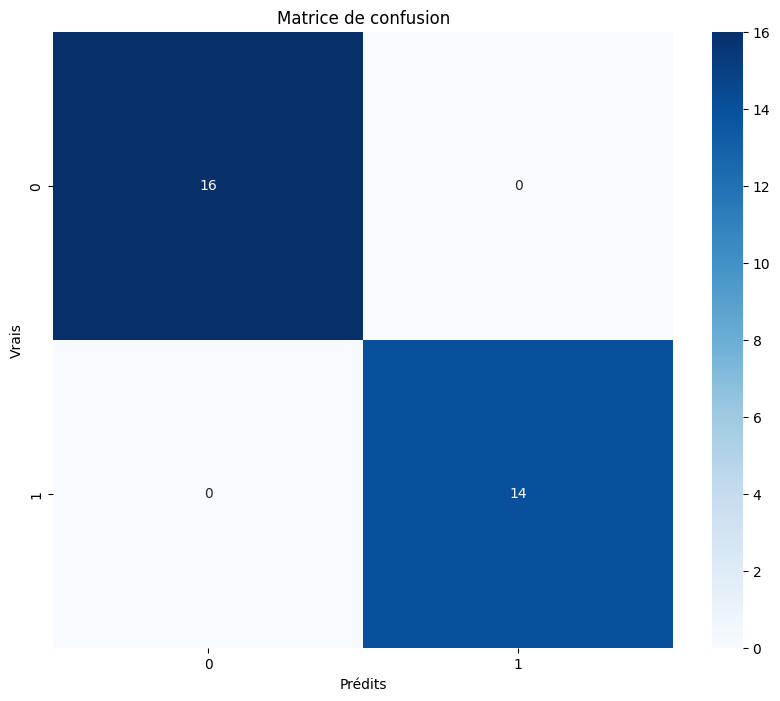

In [ ]:
X_train, X_test, y_train, y_test = creation_donnes()

modele = SVM_()
modele.fit(X_train, y_train)
y_pred = modele.predict(X_test)


print_evaluation_metrics_binary(y_test, y_pred)

Maintenant on test sur nos données

In [ ]:
best_pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

Mesures d'évaluation :
Accuracy : 0.88
Precision : 0.88
Recall : 0.88
F1 Score : 0.88


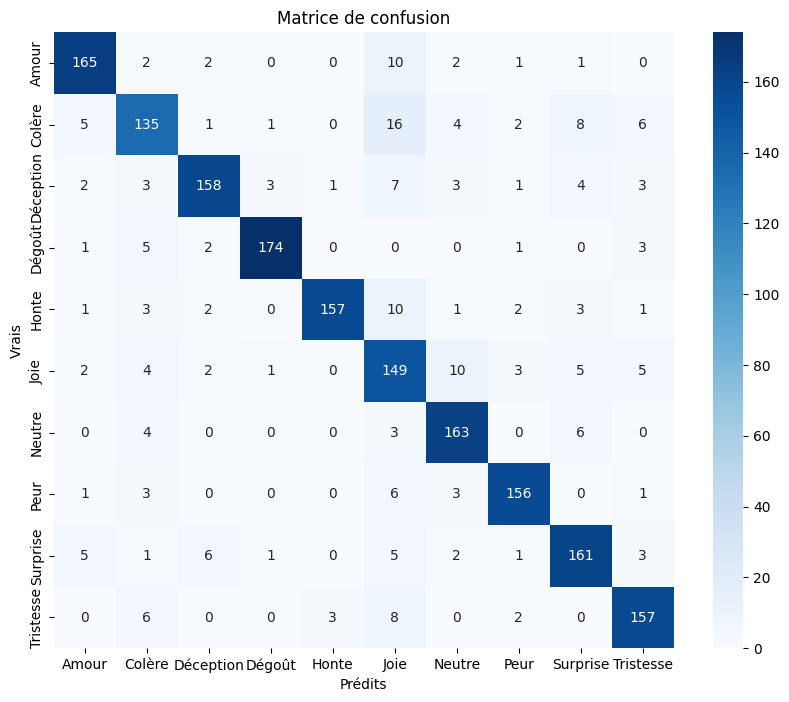

In [ ]:
best_pipeline_3.fit(X_train, y_train)

y_pred = best_pipeline_3.predict(X_test)

print_evaluation_metrics(y_test, y_pred)


# Recherche des meilleurs hyper paramètres

Les hyperparamètres sont des paramètres du modèle qui ne sont pas appris à partir des données d'entraînement, mais qui doivent être fixés avant le processus d'apprentissage. Ils affectent la performance et le comportement du modèle.


L'objectif de la recherche d'hyperparamètres est de trouver la combinaison d'hyperparamètres qui optimise les performances du modèle sur un ensemble de données donné. Cela peut impliquer l'optimisation de la précision, du rappel, de la F1-score ou d'autres mesures de performance, en fonction des besoins spécifiques du problème.

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser pour LogisticRegression
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'none'])
    C = trial.suggest_float('C', 1e-10, 1e10, log=True)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial', 'auto'])
    random_state = trial.suggest_int('random_state', 0, 100)
    verbose = trial.suggest_categorical('verbose', [0, 1, 2])
    warm_start = trial.suggest_categorical('warm_start', [False, True])
    n_jobs = trial.suggest_categorical('n_jobs', [None, -1])


    clf = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        multi_class=multi_class,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        n_jobs=n_jobs
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    # Calcul de la précision avec validation croisée
    try:
        score = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean()
    except:
        score = -float('inf')

    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

best_params = study.best_params

print("Meilleurs hyperparamètres trouvés:")
print(best_params)


[I 2024-05-09 08:43:08,057] A new study created in memory with name: no-name-3c6b0e04-1620-40ed-937a-a629b3429d4b
[I 2024-05-09 08:43:15,769] Trial 0 finished with value: 0.8152380952380952 and parameters: {'penalty': 'none', 'C': 1301360543.7074819, 'solver': 'newton-cg', 'max_iter': 378, 'class_weight': None, 'multi_class': 'ovr', 'random_state': 56, 'verbose': 2, 'warm_start': True, 'n_jobs': None}. Best is trial 0 with value: 0.8152380952380952.
[I 2024-05-09 08:43:29,257] Trial 1 finished with value: 0.8238095238095238 and parameters: {'penalty': 'none', 'C': 12120.132936954493, 'solver': 'saga', 'max_iter': 679, 'class_weight': 'balanced', 'multi_class': 'auto', 'random_state': 6, 'verbose': 1, 'warm_start': False, 'n_jobs': None}. Best is trial 1 with value: 0.8238095238095238.
[I 2024-05-09 08:43:30,516] Trial 2 finished with value: 0.10238095238095238 and parameters: {'penalty': 'l2', 'C': 8.086051051033216e-07, 'solver': 'newton-cg', 'max_iter': 687, 'class_weight': None, 'mu

Meilleurs hyperparamètres trouvés:
{'penalty': 'l2', 'C': 80.67075674980438, 'solver': 'newton-cg', 'max_iter': 552, 'class_weight': 'balanced', 'multi_class': 'ovr', 'random_state': 2, 'verbose': 1, 'warm_start': True, 'n_jobs': None}


In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser pour RandomForest
    n_estimators = trial.suggest_int('n_estimators', 90, 110)
    max_depth = trial.suggest_categorical('max_depth', [None, 32])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)


    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )


    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    score = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=100)


best_params = study.best_params

print("Meilleurs hyperparamètres trouvés:")
print(best_params)

[I 2024-05-10 11:17:25,017] A new study created in memory with name: no-name-b056c1f3-6e9f-4fdb-8c92-9119d87d29ba
[I 2024-05-10 11:17:30,504] Trial 0 finished with value: 0.6745238095238095 and parameters: {'n_estimators': 99, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6745238095238095.
[I 2024-05-10 11:17:33,976] Trial 1 finished with value: 0.696904761904762 and parameters: {'n_estimators': 92, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.696904761904762.
[I 2024-05-10 11:17:37,704] Trial 2 finished with value: 0.6314285714285715 and parameters: {'n_estimators': 92, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.696904761904762.
[I 2024-05-10 11:17:43,284] Trial 3 finished with value: 0.8095238095238095 and parameters: {'n_estimators': 95, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value

Meilleurs hyperparamètres trouvés:
{'n_estimators': 105, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [ ]:
def objective(trial):
    # Définir les hyperparamètres à optimiser
    C = trial.suggest_float('C', 0.1, 10.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])


    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_float('gamma', 0.1, 1.0, log=True)
    else:
        gamma = 'scale'

    svm_clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        random_state=42
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', svm_clf)
    ])

    score = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')


study.optimize(objective, n_trials=100)


best_params = study.best_params

print("Meilleurs hyperparamètres trouvés:")
print(best_params)


[I 2024-05-10 11:28:53,487] A new study created in memory with name: no-name-c48ef12e-9d0e-4382-907c-0983b701bcaa
[I 2024-05-10 11:29:02,792] Trial 0 finished with value: 0.8019047619047619 and parameters: {'C': 2.1180080305815103, 'kernel': 'sigmoid', 'gamma': 0.3116126258370045}. Best is trial 0 with value: 0.8019047619047619.
[I 2024-05-10 11:29:05,912] Trial 1 finished with value: 0.8269047619047619 and parameters: {'C': 1.899211882377568, 'kernel': 'linear'}. Best is trial 1 with value: 0.8269047619047619.
[I 2024-05-10 11:29:09,653] Trial 2 finished with value: 0.7976190476190477 and parameters: {'C': 1.5922368333947128, 'kernel': 'rbf', 'gamma': 0.1763113747667568}. Best is trial 1 with value: 0.8269047619047619.
[I 2024-05-10 11:29:13,454] Trial 3 finished with value: 0.8147619047619049 and parameters: {'C': 6.927773751825352, 'kernel': 'sigmoid', 'gamma': 0.7176777174241517}. Best is trial 1 with value: 0.8269047619047619.
[I 2024-05-10 11:29:17,581] Trial 4 finished with valu

Meilleurs hyperparamètres trouvés:
{'C': 3.9773816578958763, 'kernel': 'rbf', 'gamma': 0.9512433603206667}


# Résultats avec le classifieur LogisticRegression

In [ ]:
# Paramètres de la régression logistique
logistic_params = {
    'penalty': 'l2',
    'C': 80.67075674980438,
    'solver': 'newton-cg',
    'max_iter': 552,
    'class_weight': 'balanced',
    'multi_class': 'ovr',
    'random_state': 2,
    'verbose': 1,
    'warm_start': True,
    'n_jobs': None
}

# Création du pipeline
lc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(**logistic_params))
])

Mesures d'évaluation :
Accuracy : 0.86
Precision : 0.87
Recall : 0.86
F1 Score : 0.86


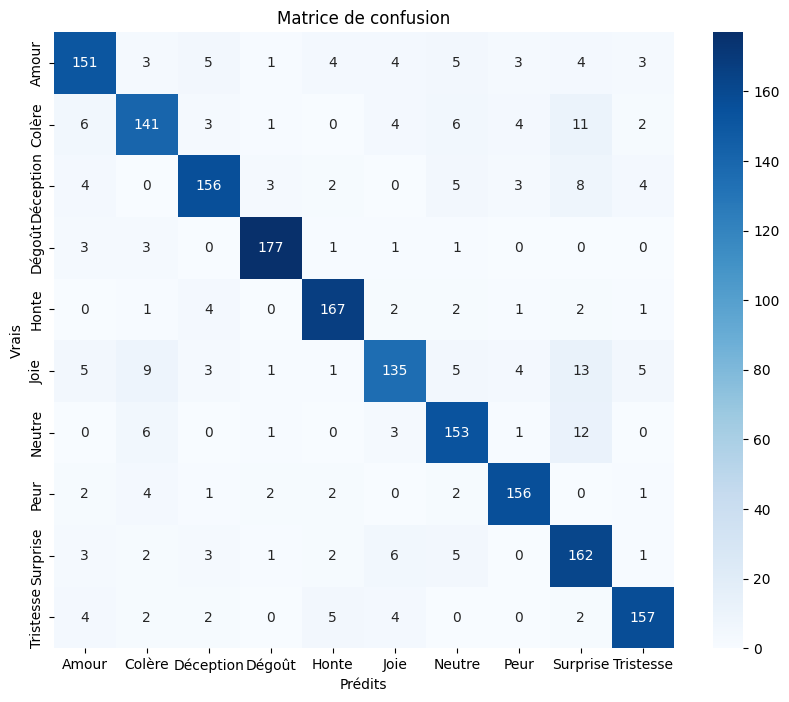

In [ ]:
lc_pipeline.fit(X_train, y_train)

y_pred = lc_pipeline.predict(X_test)

print_evaluation_metrics(y_test, y_pred)


# Résultats avec le classifieur Random Forest

In [ ]:
# Paramètres du classifieur Naive Bayes Multinomial
rf_params = {
    'n_estimators': 105,
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 1
}

# Création du pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(**rf_params))
])

Mesures d'évaluation :
Accuracy : 0.84
Precision : 0.85
Recall : 0.84
F1 Score : 0.84


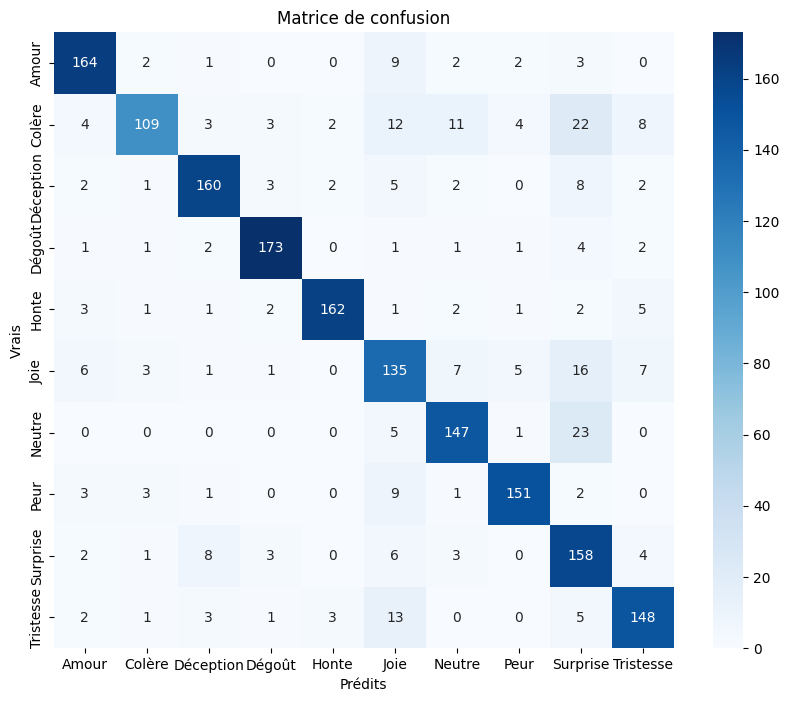

In [ ]:
rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print_evaluation_metrics(y_test, y_pred)


# Résultats avec le classifieur SVC

In [ ]:
# Paramètres du classifieur SVM
svm_params = {
    'C': 3.9773816578958763,
    'kernel': 'rbf',
    'gamma': 0.9512433603206667
}

# Création du pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC(probability=True,**svm_params))
])

Mesures d'évaluation :
Accuracy : 0.88
Precision : 0.89
Recall : 0.88
F1 Score : 0.88


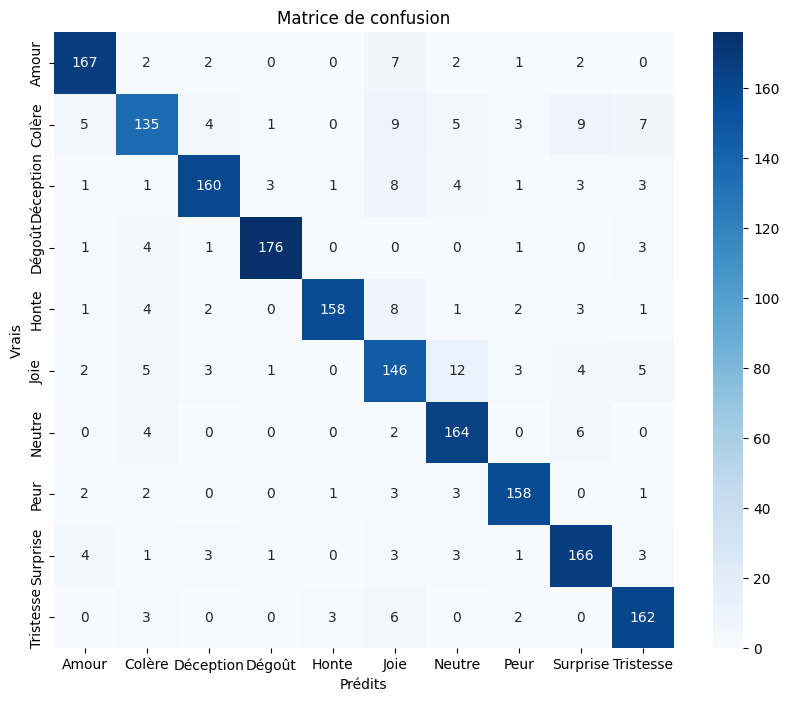

In [ ]:
svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)

print_evaluation_metrics(y_test, y_pred)


# Classifieur de Vote

Un classifieur de vote, également connu sous le nom de classifieur d’ensemble par vote
majoritaire, est un algorithme d’apprentissage automatique qui combine les prédictions
de plusieurs modèles de base pour faire une prédiction finale. Chaque modèle de base fait
une prédiction (vote) pour chaque échantillon de test et la prédiction finale est la classe
qui reçoit le plus de votes. Si tous les modèles de base ont le même poids, on parle de
vote majoritaire simple. Si différents modèles ont des poids différents, on parle de vote
majoritaire pondéré.



Mesures d'évaluation :
Accuracy : 0.87
Precision : 0.88
Recall : 0.87
F1 Score : 0.88


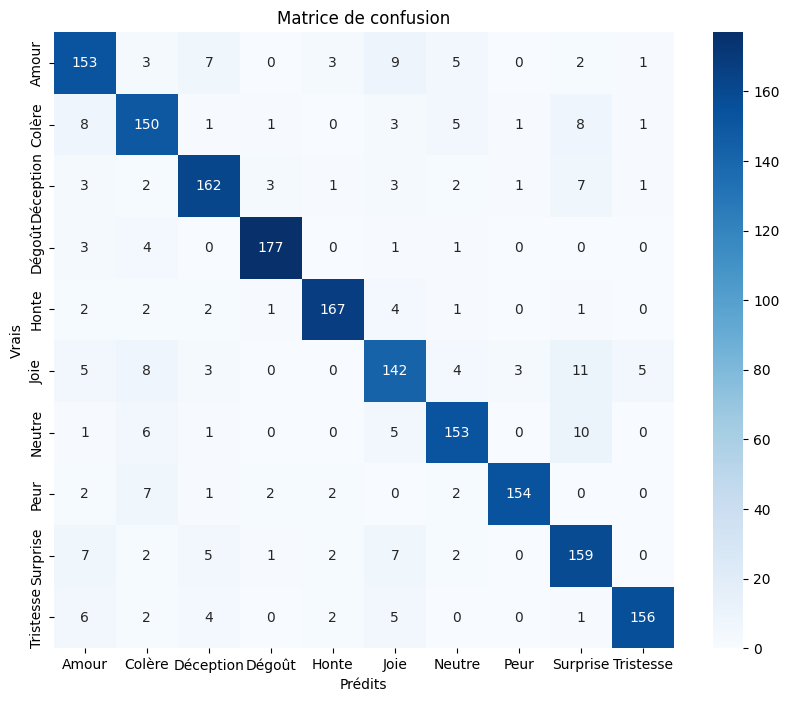

In [ ]:
modele = VotingClassifier(
    estimators=[
        ('logreg', lc_pipeline),
        ('rf', rf_pipeline),
        ('svm', svm_pipeline)
    ],
    voting='hard'
)

modele.fit(X_train, y_train)

y_pred = modele.predict(X_test)

print_evaluation_metrics(y_test, y_pred)

# Notre modèle


Notre objectif est de développer un modèle à la fois fiable et performant. Pour y
parvenir, nous allons mettre en œuvre plusieurs techniques d’apprentissage automatique.

In [ ]:
best_classifiers = {}

# Pour chaque classe
for class_label in np.unique(y_train):
    # Préparer les étiquettes de classe pour le classifieur one-versus-rest
    y_train_binary = np.where(y_train == class_label, 1, 0)
    y_test_binary = np.where(y_test == class_label, 1, 0)

    # Entraîner le classifieur SVM
    svm_pipeline.fit(X_train, y_train_binary)
    lc_pipeline.fit(X_train,y_train_binary)
    rf_pipeline.fit(X_train, y_train_binary)

    joblib.dump(svm_pipeline, f'svm_model_{class_label}.joblib')
    joblib.dump(lc_pipeline, f'lc_model_{class_label}.joblib')
    joblib.dump(rf_pipeline, f'rf_model_{class_label}.joblib')
    # Prédire sur l'ensemble de test
    y_pred_svm = svm_pipeline.predict(X_test)
    y_pred_rf = rf_pipeline.predict(X_test)
    y_pred_lc = lc_pipeline.predict(X_test)
    # Calculer l'exactitude
    accuracy_svm = accuracy_score(y_test_binary, y_pred_svm)
    accuracy_rf = accuracy_score(y_test_binary, y_pred_rf)
    accuracy_lc = accuracy_score(y_test_binary,y_pred_lc)
    # Calculer la matrice de confusion
    confusion_svm = confusion_matrix(y_test_binary, y_pred_svm)
    confusion_rf = confusion_matrix(y_test_binary, y_pred_rf)
    confusion_lc = confusion_matrix(y_test_binary,y_pred_lc)
    # Stocker le classifieur, l'exactitude et la matrice de confusion dans le dictionnaire

    best_classifiers[class_label] = {
        'SVM': (accuracy_svm, confusion_svm),
        'Random Forest': (accuracy_rf, confusion_rf),
        'Logistic Regression' : (accuracy_lc,confusion_lc),
    }

# Trouver le meilleur classifieur pour chaque classe
best_classifiers_per_class = {}
for class_label, classifiers_data in best_classifiers.items():
    best_classifier = max(classifiers_data, key=lambda k: classifiers_data[k][0])
    best_classifiers_per_class[class_label] = (best_classifier, classifiers_data[best_classifier])

print(best_classifiers_per_class)


{'Amour': ('SVM', (0.9755555555555555, array([[1611,    6],
       [  38,  145]]))), 'Colère': ('SVM', (0.9716666666666667, array([[1620,    2],
       [  49,  129]]))), 'Déception': ('SVM', (0.9833333333333333, array([[1610,    5],
       [  25,  160]]))), 'Dégoût': ('SVM', (0.9872222222222222, array([[1609,    5],
       [  18,  168]]))), 'Honte': ('SVM', (0.99, array([[1619,    1],
       [  17,  163]]))), 'Joie': ('Logistic Regression', (0.9555555555555556, array([[1590,   29],
       [  51,  130]]))), 'Neutre': ('SVM', (0.9794444444444445, array([[1616,    8],
       [  29,  147]]))), 'Peur': ('SVM', (0.9861111111111112, array([[1629,    1],
       [  24,  146]]))), 'Surprise': ('SVM', (0.9722222222222222, array([[1608,    7],
       [  43,  142]]))), 'Tristesse': ('SVM', (0.9833333333333333, array([[1624,    0],
       [  30,  146]])))}


In [ ]:
model_paths = {
    'Amour': 'svm_model_Amour.joblib',
    'Colère': 'svm_model_Colère.joblib',
    'Déception': 'svm_model_Déception.joblib',
    'Dégoût': 'svm_model_Dégoût.joblib',
    'Honte': 'svm_model_Honte.joblib',
    'Joie': 'lc_model_Joie.joblib',
    'Neutre': 'svm_model_Neutre.joblib',
    'Peur': 'svm_model_Peur.joblib',
    'Surprise': 'svm_model_Surprise.joblib',
    'Tristesse': 'svm_model_Tristesse.joblib',
}

In [ ]:
class notre_modele:
    def __init__(self, model_paths):
        self.models = {}
        for class_label, model_path in model_paths.items():
            self.models[class_label] = joblib.load(model_path)

    def predict(self, data):
        emotion = modele.predict(data)[0]
        ovrs_classifier = self.models[emotion]
        ovrs_prediction = ovrs_classifier.predict(data)[0]

        if ovrs_prediction == 1:
            return emotion
        else:
            label = None
            for class_label, classifier in self.models.items():
                ovrs_prediction = classifier.predict(data)[0]

                if ovrs_prediction == 1:
                    label = class_label
                    break

            if label is not None:
                return label
            else:
                return emotion


In [ ]:
emotion_classifier = notre_modele(model_paths)
joblib.dump(emotion_classifier, f'emotion_classifier.joblib')

['emotion_classifier.joblib']

In [ ]:
def list_predict(list):
  predictions = []
  for data in list:
    emotion = emotion_classifier.predict([data])
    predictions.append(emotion)
  return predictions

Mesures d'évaluation :
Accuracy : 0.89
Precision : 0.89
Recall : 0.89
F1 Score : 0.89


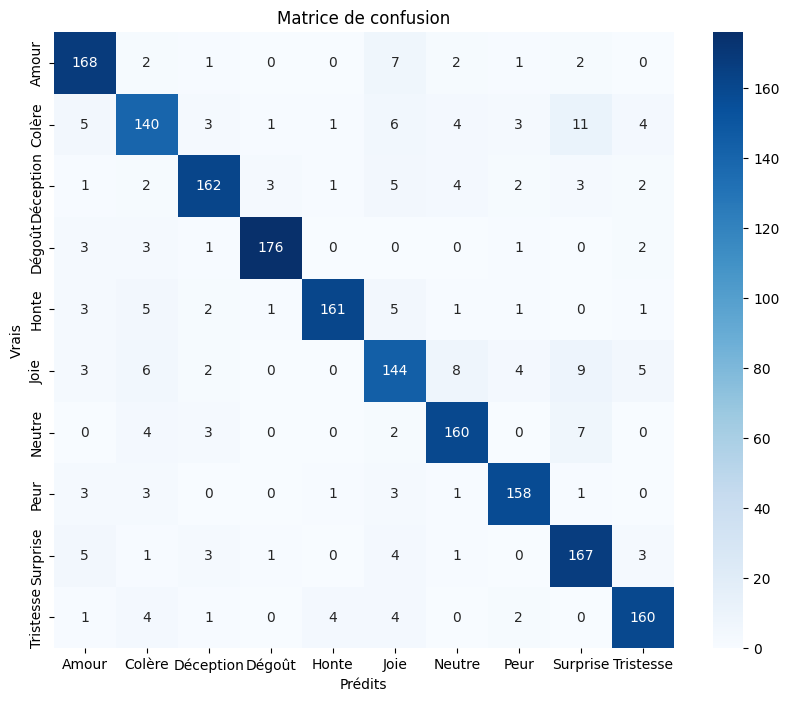

In [ ]:
y_pred = list_predict(X_test)
print_evaluation_metrics(y_test, y_pred)

In [ ]:
dialogue = [
    ("C'est vous-même !","Surprise"),
    ("Non, pas moi.","Neutre ou Colère"),
    ("C'est vraiment déprimant de voir ça.","Tristesse ou Déception"),
    ("Vous ne pensiez pas !","Colère ou Surprise"),
    ("Je me sens mal à l'aise dans cette situation.","Tristesse"),
    ("Ça me rend malade juste d'y penser.", "Dégoût ou colère"),
    ("Je suis terrifié à l'idée de ce que l'avenir nous réserve dans ce monde en guerre.", "Peur")
]



predicted_emotions = list_predict([sentence for sentence, _ in dialogue])

In [ ]:
for (sentence, emotions_obs), predicted_emotion in zip(dialogue, predicted_emotions):
    print(f"{sentence}")
    print(f"Émotion prédite : {predicted_emotion}")
    print(f"Émotions observée : {emotions_obs}")
    print("-" * 50)


C'est vous-même !
Émotion prédite : Surprise
Émotions observée : Surprise
--------------------------------------------------
Non, pas moi.
Émotion prédite : Colère
Émotions observée : Neutre ou Colère
--------------------------------------------------
C'est vraiment déprimant de voir ça.
Émotion prédite : Déception
Émotions observée : Tristesse ou Déception
--------------------------------------------------
Vous ne pensiez pas !
Émotion prédite : Surprise
Émotions observée : Colère ou Surprise
--------------------------------------------------
Je me sens mal à l'aise dans cette situation.
Émotion prédite : Tristesse
Émotions observée : Tristesse
--------------------------------------------------
Ça me rend malade juste d'y penser.
Émotion prédite : Colère
Émotions observée : Dégoût ou colère
--------------------------------------------------
Je suis terrifié à l'idée de ce que l'avenir nous réserve dans ce monde en guerre.
Émotion prédite : Surprise
Émotions observée : Peur
-----------

In [ ]:
conversation = [
    "Oh mon Dieu, où sommes-nous ? Il fait presque nuit et je ne reconnais aucun de ces arbres !",
    "Ne t'inquiète pas, on va trouver notre chemin. Regarde, je crois qu'on peut suivre cette direction pour retrouver le sentier.",
    "Je ne peux pas croire que quelqu'un ait fait ça à ma voiture ! C'est une honte ! Je vais trouver qui a fait ça et lui faire payer !",
    "Hmm, je suis content d'avoir pris ce livre avec moi. Ça aide à passer le temps en attendant le train.",
    "Encore une lettre inutile. Je pensais vraiment que c'était une offre d'emploi cette fois-ci. Je suis tellement déçue.",
    "Beurk, mais c'est quoi ça dans mon plat ? C'est absolument répugnant ! Serveur, il y a un problème avec ma commande !",
    "Je vais tellement manquer à grand-père. Il était toujours là pour moi. C'est tellement difficile de dire au revoir.",
    "Je suis vraiment désolé, j'ai complètement oublié ton anniversaire. C'est impardonnable de ma part.",
    "Mon amour, tu es la personne la plus incroyable que j'ai jamais rencontrée. Je suis tellement reconnaissante de t'avoir dans ma vie. Je t'aime tellement.",
    "Oh wow ! Une fête surprise ? Pour moi ? Je ne m'y attendais pas du tout ! Vous êtes les meilleurs amis qu'on puisse avoir !"
]

In [ ]:
predicted_emotions = list_predict([sentence for sentence in conversation])

for sentence, predicted_emotion in zip(conversation, predicted_emotions):
    print(f"({predicted_emotion}) {sentence}")


(Neutre) Oh mon Dieu, où sommes-nous ? Il fait presque nuit et je ne reconnais aucun de ces arbres !
(Neutre) Ne t'inquiète pas, on va trouver notre chemin. Regarde, je crois qu'on peut suivre cette direction pour retrouver le sentier.
(Colère) Je ne peux pas croire que quelqu'un ait fait ça à ma voiture ! C'est une honte ! Je vais trouver qui a fait ça et lui faire payer !
(Surprise) Hmm, je suis content d'avoir pris ce livre avec moi. Ça aide à passer le temps en attendant le train.
(Déception) Encore une lettre inutile. Je pensais vraiment que c'était une offre d'emploi cette fois-ci. Je suis tellement déçue.
(Dégoût) Beurk, mais c'est quoi ça dans mon plat ? C'est absolument répugnant ! Serveur, il y a un problème avec ma commande !
(Colère) Je vais tellement manquer à grand-père. Il était toujours là pour moi. C'est tellement difficile de dire au revoir.
(Joie) Je suis vraiment désolé, j'ai complètement oublié ton anniversaire. C'est impardonnable de ma part.
(Amour) Mon amour, tu